In [7]:
# Dependencies
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt


# Own Dependencies
from lib.Visualize import visualize_points_and_circle
from lib.RANSAC import Ransac,Circle

In [10]:
# Question 01 : Circle fitting RANSAC

# np.random.seed(0)
N=100
half_n=N//2
r=10
s=r/16
t=np.random.uniform(0,2*np.pi,half_n)
n=s*np.random.randn(half_n)
x,y=(r+n)*np.cos(t),(r+n)*np.sin(t)
x_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
m,b=1,2
x=np.linspace(-12,12,half_n)
y=n*x+b+s*np.random.randn(half_n)
x_line=np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
X=np.vstack((x_circ,x_line))

In [15]:
threshold = 1
ransac_run = Ransac(X,1)
print(ransac_run)

Model Parameters :  X=-0.212242 Y=-0.525753 R=9.751878
Number of Samples = 100 
 Iterations Done = 28
 Inliers Count : 51


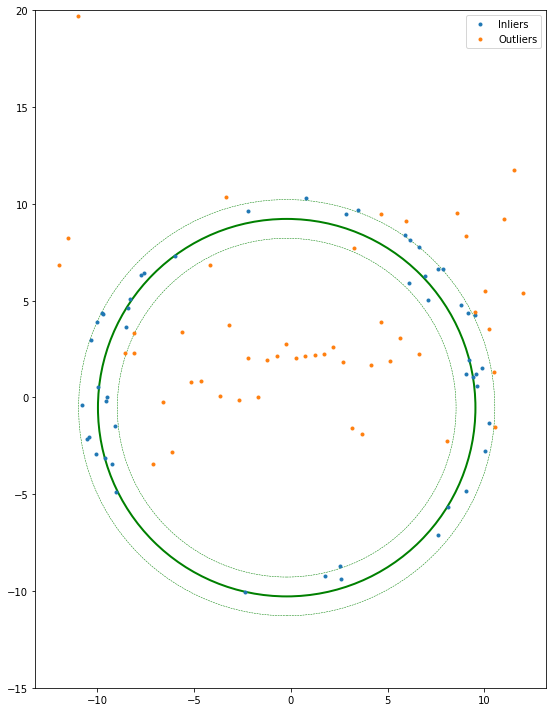

In [22]:
circle = ransac_run.get_model()
inliers,outliers = ransac_run.get_inliers_outliers()
visualize_points_and_circle(points_list=[inliers,outliers],circles_list=[[circle.X,circle.Y,circle.R,threshold]],legends=["Inliers","Outliers"],y_lim=[-15,20])